# Advantage Actor Critic (A2C)

In [1]:
import numpy as np
import time
import random
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from IPython.display import clear_output
%matplotlib inline

### Checking for cuda device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# env = gym.make('HalfCheetah-v2')

# print('Observation Shape:', env.observation_space.shape, '\nAction Shape:', env.action_space)
# env.reset()
# for _ in range(100):
#     env.render()
#     time.sleep(0.01)
#     env.step(env.action_space.sample())   # take random actions  
# env.close()

### Creating Multiple Agents of Environment

In [4]:
from multiprocessing_env import SubprocVecEnv

num_envs = 16
env_id = 'HalfCheetah-v2'

def make_env():
    def _thunk():
        env = gym.make(env_id)
        return env
    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

env = gym.make(env_id)

### Initialization of Hyperparameters

In [5]:
LEARNING_RATE = 0.0003
DISCOUNT = 0.99
EPS = 1
EPS_DECAY = 0.9999
END_EPS = 0.1

N_EPISODE = 50000


# Dimensions of input and output of environment
obs_dim = envs.observation_space.shape[0]
action_dim = envs.action_space.shape[0]

# print(obs_dim, action_dim)

### Actor Network

In [6]:
class Actor(nn.Module):
    def __init__(self, observations, actions):
        super(Actor, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(observations, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.l1 = nn.Linear(32, actions)
        self.l2 = nn.Linear(32, actions)
#         self.t = nn.Tanh()
    def forward(self, x):
        x = self.actor(x)
        mean = self.l1(x)
        variance = F.softplus(self.l2(x))
        
        return mean, variance

In [7]:
actor = Actor(obs_dim, action_dim).to(device)
optimizerA = optim.Adam(actor.parameters(), lr = LEARNING_RATE)

### Sampling of action from Normal Distribution

In [8]:
def actors_action(state):
    
    mean, variance = actor(state)
    
    m = torch.distributions.Normal(mean, torch.sqrt(variance))
    action = m.sample()
    log_prob = m.log_prob(action)
    
    return action.detach().cpu().numpy(), log_prob

### Critic Network

In [9]:
class Critic(nn.Module):
    def __init__(self, observations, actions):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(observations, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, actions)
        )
    
    def forward(self, x):
        return self.network(x)

In [10]:
critic = Critic(obs_dim, action_dim).to(device)
optimizerC = optim.Adam(critic.parameters(), lr = LEARNING_RATE)

### Computing Q-Values

In [11]:
def compute_returns(next_state, rewards, done, discount = DISCOUNT):
#     q_val = critic(state)

    next_state = torch.FloatTensor(next_state).to(device)
    next_q_val = critic(next_state)
    returns = []
    
    for step in reversed(range(len(rewards))):
        next_q_val = rewards[step] + discount*next_q_val*(1-done[step])
        returns.append(next_q_val)
        
    returns.reverse()
    
    return returns  

### Updating Actor based on Q-values by critic

In [12]:
actor_loss = 0
critic_loss = 0
def ACupdate(log_probs, q_vals, values):

#     print(log_probs.shape)
    advantage = q_vals - values

    actor_loss = (-log_probs*advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    
#     for itr in range(len(log_probs)):
#         log_prob = log_probs[itr]
#         retr = ret[itr]
#         value = values[itr]
        
#         actor_loss -= torch.sum(log_prob*retr)
# #         print('AL', actor_loss)
        
# #         print(criterionC(value, retr))
#         critic_loss += criterionC(value, retr.detach())
    optimizerA.zero_grad()
    optimizerC.zero_grad()
    
    actor_loss.backward()
    critic_loss.backward()
    
    optimizerA.step()
    optimizerC.step()

In [13]:
mean_avg = []
def plot(n_rewards, maximum):
    clear_output(True)
    plt.figure(figsize=(22,10))
    mean = np.mean(n_rewards[-50:])
#     plt.subplot(131)
    mean_avg.append(mean)
    plt.title('Reward: %.4f | Maximum %.4f' % (mean, maximum))
    plt.plot(n_rewards)
#     plt.plot(mean_avg)
#   plt.subplot(132)
#   plt.title('loss')
#   plt.plot(losses)
    plt.show()

In [14]:
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        action, log_prob = actors_action(state)
    
        next_state, reward, done, _ = env.step(action)
        state = next_state
        
        total_reward += reward
    return total_reward

### Training QAC

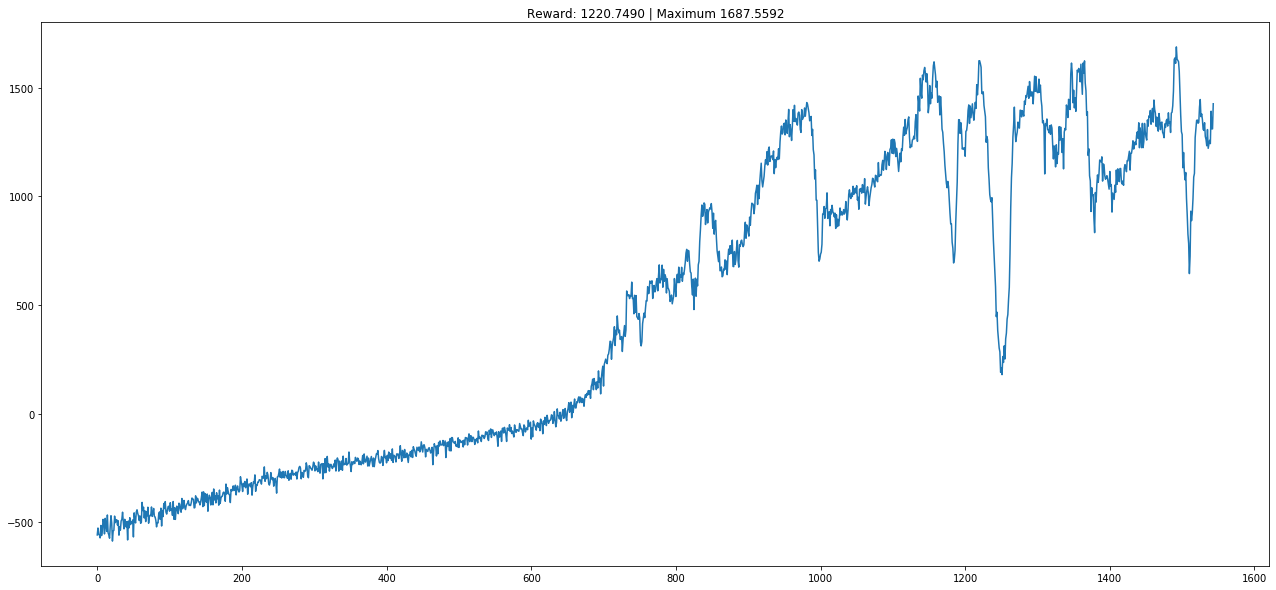

In [ ]:
n_rewards = []
maximum = -10000
total_reward = []
for i in range(1, N_EPISODE+1):
    ep_rewards = []
    log_probs = []
    done_states = []
#     returns = []
    values = []
    
    state = envs.reset()
    ret = 0
    
    while True:
        state = torch.FloatTensor(state).to(device)
        action, log_prob = actors_action(state)
        
        value = critic(state)
        
        next_state, reward, done, _ = envs.step(action)
        
        
        ep_rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        log_probs.append(log_prob)
        done_states.append(torch.FloatTensor(done).unsqueeze(1).to(device))
        values.append(value)

#         total_reward += reward
#         ret = compute_returns(next_state, reward, done, ret)
#         if i%5 == 0:
#             env.render()
        state = next_state
        
        if done.all() == True :
#             print(done)
            break
    ob_reward = np.mean([test_env() for _ in range(10)])
    total_reward.append(ob_reward) 
    q_vals = compute_returns(next_state, ep_rewards, done_states)
    q_vals = torch.cat(q_vals).detach()
    values = torch.cat(values)
    log_probs = torch.cat(log_probs)
    
#     print(values, q_vals, log_probs)
    ACupdate(log_probs, q_vals, values)
    
#     n_rewards.append(total_reward)
    
    if ob_reward >= maximum:
        torch.save(actor.state_dict(), 'adv-actor_halfcheetah.pth')
        torch.save(critic.state_dict(), 'adv-critic_halfcheetah.pth')
        maximum = ob_reward
        print("Model Saved")
    
    plot(total_reward, maximum)

In [ ]:
# state = env.reset()


# total_reward = 0
# done = False

# actor.load_state_dict(torch.load('/home/himanshu/RL/Policy-based-RL/adv-actor_halfcheetah.pth'))
# critic.load_state_dict(torch.load('/home/himanshu/RL/Policy-based-RL/adv-critic_halfcheetah.pth'))
# print("Model Loaded")
# actor.to(device)
# critic.to(device)

# while not done:
#     state = torch.FloatTensor(state).to(device)
#     action, log_prob = actors_action(state)
    
#     next_state, reward, done, _ = env.step(action)
#     total_reward += reward
    
#     env.render()
#     time.sleep(0.01)
    
#     state = next_state
    
# print('Duration till which pole is balanced: ', total_reward)

# env.close()